<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical

### Download the dataset from internet and extract it on the system

**We resized all images to 500x500 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB1: the csv file is a bit modified. replace space by underscore in artists names, set one genre per artists.

NB2: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [4]:
zipurl = 'https://download1327.mediafire.com/kynr0mivrk6g/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

We first want to make a binary classification between 2 genre well represented in the dataset. We choose Impressionism and Baroque.

## Extracting metadata from artist.csv and labelize genres

In [5]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
name=artists.name

##genre of artists
genre=artists.genre

##number of paintings by artists
nb_paints=artists.paintings

Labelize a genre with a number

In [6]:
genre_label={'Impressionism':0,'Baroque':1}

In [7]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [8]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [9]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape#shape of images
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #selected artists in order to have ~50/50 impressionism/Baroque

for i in genre1:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])

artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

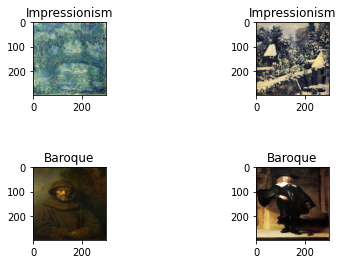

In [10]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

## Shuffle and split of the dataset

In [11]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes) #convert label into a matrix eg: label 0 --> [1,0]; label 1 --> [0,1]

In [12]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)
#split and shuffle the dataset into train and test datasets

## CNN

This is the Convolutional Network

In [13]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
dense (Dense)                (None, 71, 71, 100)       12900     
_________________________________________________________________
dropout (Dropout)            (None, 71, 71, 100)       0

In [16]:
history=model.fit(x_train,y_train, batch_size=64, epochs=12, validation_split=0.33)

Epoch 1/12
9/9 [==============================] - 49s 1s/step - loss: 234.6515 - accuracy: 0.5446 - val_loss: 16.1467 - val_accuracy: 0.6619
Epoch 2/12
9/9 [==============================] - 5s 571ms/step - loss: 12.1439 - accuracy: 0.6580 - val_loss: 5.2551 - val_accuracy: 0.7662
Epoch 3/12
9/9 [==============================] - 5s 568ms/step - loss: 5.7938 - accuracy: 0.7274 - val_loss: 2.2888 - val_accuracy: 0.8165
Epoch 4/12
9/9 [==============================] - 5s 570ms/step - loss: 1.1850 - accuracy: 0.8425 - val_loss: 1.2075 - val_accuracy: 0.8525
Epoch 5/12
9/9 [==============================] - 5s 572ms/step - loss: 0.6431 - accuracy: 0.8623 - val_loss: 0.6992 - val_accuracy: 0.8885
Epoch 6/12
9/9 [==============================] - 5s 574ms/step - loss: 0.3326 - accuracy: 0.9106 - val_loss: 0.6442 - val_accuracy: 0.8705
Epoch 7/12
9/9 [==============================] - 5s 575ms/step - loss: 0.2762 - accuracy: 0.9141 - val_loss: 0.4373 - val_accuracy: 0.8885
Epoch 8/12
9/9 [==

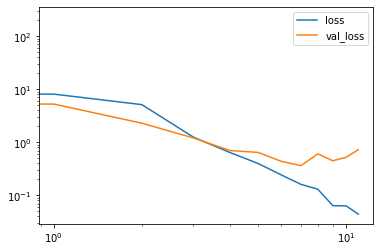

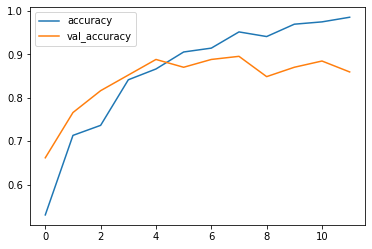

In [17]:
plt.figure()
plt.loglog(history.history['loss'],label='loss')#first values are often bigger than the rest
plt.loglog(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [18]:
predict=model.predict(x_test)

In [19]:
label_prediction=np.argmax(predict, axis=1)
#select the label with the highest probability eg: [0.2,0.8] --> label_prediction=1, [0.7,0.3] --> label_prediction=0
label_solution=np.argmax(y_test, axis=1)#select the label of the solution eg: [0,1] --> label_prediction=1, [1,0] --> label_prediction=0

visualisation of random predictions with solutions

Text(0.5, 1.0, 'prediction:Baroque\n solution:Baroque')

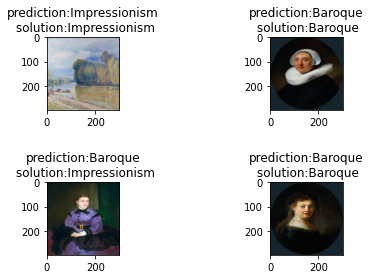

In [20]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [21]:
correct=len(np.where(label_prediction==label_solution)[0]) #count the number of correct prediction
bad=len(np.where(label_prediction!=label_solution)[0]) #count the number of incorrect prediction

In [22]:
efficacity=correct/(correct+bad)
print(efficacity)

0.8743961352657005


## Add the rest of the dataset 

Labelize a genre with a number

In [23]:
k=0
genre_label={}
for i in range(len(genre)):
  if genre[i] in genre_label:#if the genre already in the dictionnary, ignore
    continue
  else:#else add it with an interger and increase it
    genre_label[genre[i]]=k
    k+=1

In [24]:
genre_label

{'Abstract Expressionism': 23,
 'Abstractionism': 1,
 'Baroque': 12,
 'Byzantine Art': 6,
 'Cubism': 11,
 'Early Renaissance': 17,
 'Expressionism': 0,
 'Fauvism': 19,
 'High Renaissance': 18,
 'Impressionism': 3,
 'Mannerism': 14,
 'Muralism': 2,
 'Neoplasticism': 21,
 'Northern Renaissance': 9,
 'Pop Art': 22,
 'Post-Impressionism': 7,
 'Primitivism': 15,
 'Proto Renaissance': 16,
 'Realism': 20,
 'Romanticism': 13,
 'Suprematism': 10,
 'Surrealism': 4,
 'Symbolism': 8,
 'impressionism': 5}

In [25]:
nb_classes=len(genre_label)

Some genre are over represented so we reduce this in the section bellow

In [26]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
list_genre=list(genre_label.keys())#list of genre
nb_aw_per_genre=min(nb_paints)#number of artworks per artists
artworks=[]
artworks_genre=[]

for i in list_genre:
  index_genre=np.where(genre==i)[0]
  for j in index_genre: #for each genre, for each artists it append a fraction of random artworks
    R=np.random.randint(1,nb_paints[j]+1,size=(nb_aw_per_genre//len(index_genre)))
    for k in R:
      artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[j]}_{k}.jpg'))
      artworks_genre.append(i)
artworks=np.array(artworks) #now, artworks contains 24 images per genre
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

plot random images

Text(0.5, 1.0, 'Romanticism')

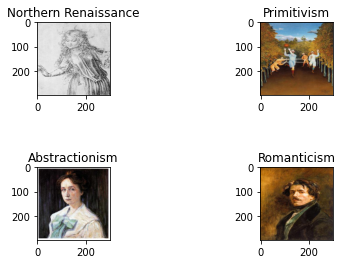

In [27]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[r1])
plt.title(f'{artworks_genre[r1]}')
plt.subplot(222)
plt.imshow(artworks[r2])
plt.title(f'{artworks_genre[r2]}')
plt.subplot(223)
plt.imshow(artworks[r3])
plt.title(f'{artworks_genre[r3]}')
plt.subplot(224)
plt.imshow(artworks[r4])
plt.title(f'{artworks_genre[r4]}')

Matrix of the labels

In [28]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

Shuffle and split of the dataset

In [29]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

In [36]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
dense_6 (Dense)              (None, 71, 71, 100)       12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 71, 71, 100)      

In [39]:
history=model.fit(x_train,y_train, batch_size=64, epochs=10, validation_split=0.33)

Epoch 1/10
4/4 [==============================] - 8s 2s/step - loss: 318.1695 - accuracy: 0.0517 - val_loss: 248.8913 - val_accuracy: 0.0397
Epoch 2/10
4/4 [==============================] - 2s 643ms/step - loss: 232.8752 - accuracy: 0.0434 - val_loss: 78.8252 - val_accuracy: 0.0476
Epoch 3/10
4/4 [==============================] - 2s 645ms/step - loss: 68.8093 - accuracy: 0.0862 - val_loss: 23.2523 - val_accuracy: 0.1032
Epoch 4/10
4/4 [==============================] - 2s 644ms/step - loss: 18.7454 - accuracy: 0.0987 - val_loss: 8.6193 - val_accuracy: 0.0794
Epoch 5/10
4/4 [==============================] - 2s 641ms/step - loss: 6.2923 - accuracy: 0.0867 - val_loss: 4.5190 - val_accuracy: 0.0556
Epoch 6/10
4/4 [==============================] - 2s 645ms/step - loss: 3.0317 - accuracy: 0.2592 - val_loss: 3.5708 - val_accuracy: 0.0397
Epoch 7/10
4/4 [==============================] - 2s 644ms/step - loss: 2.4493 - accuracy: 0.3549 - val_loss: 3.2091 - val_accuracy: 0.0873
Epoch 8/10
4/

In [40]:
predict=model.predict(x_test)

In [41]:
label_prediction=np.argmax(predict, axis=1)
label_solution=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'prediction:Baroque\n solution:impressionism')

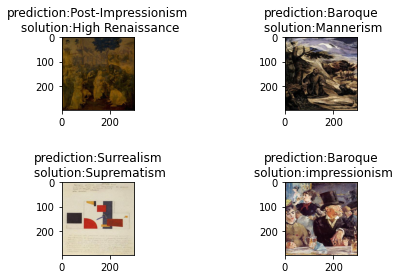

In [42]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [43]:
correct=len(np.where(label_prediction==label_solution)[0])
bad=len(np.where(label_prediction!=label_solution)[0])

In [44]:
efficacity=correct/bad
print(efficacity)

0.12574850299401197
